## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import pickle

from scipy.ndimage.measurements import label

import time

from moviepy.editor import VideoFileClip
from functools import reduce

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,9)

In [3]:
def show_images(img1, img2, title1='Original Image', title2='New Image', fsize=20):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=fsize)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2, fontsize=fsize)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Step 1: Dataset Summary & Exploration

Goals:
* explore the vehicle and non-vehicle images training dataset
* arrange the images into train, validation, test sets 
* convert to pickle format

In [4]:
# load the images
car_fnames = glob.glob('train_data/vehicles/**/*.png')
noncar_fnames = glob.glob('train_data/non-vehicles/**/*.png')
car_image = mpimg.imread(car_fnames[0])
noncar_image = mpimg.imread(noncar_fnames[0])
print('Number of car images: {}'.format(len(car_fnames)))
print('Number of non-car images: {}'.format(len(noncar_fnames)))
print('Image shape {} and type {}'.format(car_image.shape, car_image.dtype))

Number of car images: 8792
Number of non-car images: 8968
Image shape (64, 64, 3) and type float32


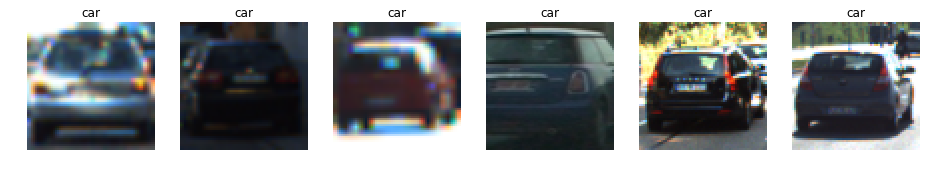

In [5]:
# visualize the data
def visualize_data(fnames, title='car'):
    num_visualize = 6
    f, axs = plt.subplots(1,num_visualize, figsize=(16,16))
    axs = axs.ravel()
    for i in range(num_visualize):
        index = np.random.randint(0, len(fnames))
        img = mpimg.imread(fnames[index])
        axs[i].set_title(title)
        axs[i].axis('off')
        axs[i].imshow(img)
visualize_data(car_fnames, 'car')

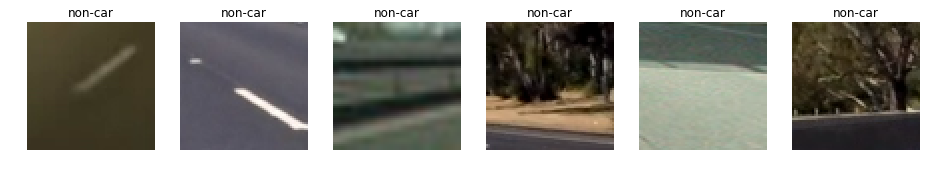

In [6]:
visualize_data(noncar_fnames, 'non-car')

In [7]:
def convert_color(image, cspace='YCrCb'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'Gray':
            return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else: return np.copy(image)

### Feature Extraction
#### 1. Histogram of Orientation (HOG)

In [8]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

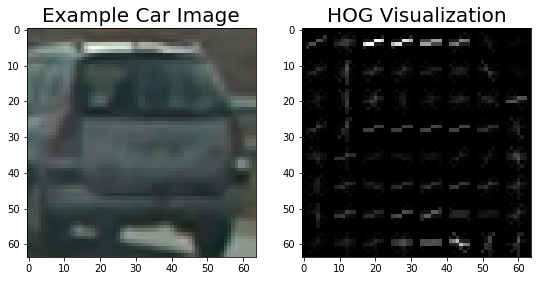

In [9]:
gray = convert_color(car_image, 'Gray')

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 1, 
                        vis=True, feature_vec=False)


show_images(car_image, hog_image, title1='Example Car Image', title2='HOG Visualization')

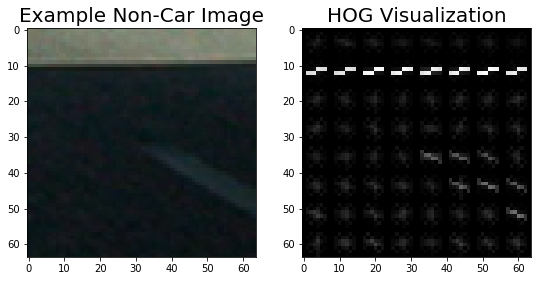

In [10]:
gray = convert_color(noncar_image, 'Gray')

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 1, 
                        vis=True, feature_vec=False)


show_images(noncar_image, hog_image, title1='Example Non-Car Image', title2='HOG Visualization')

#### 2. Spatial Binning

In [11]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(8, 8)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

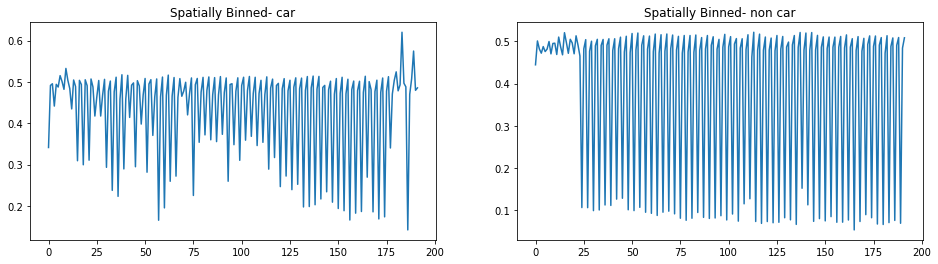

In [12]:
car_ycrcb = convert_color(car_image, 'YCrCb')
noncar_ycrcb = convert_color(noncar_image, 'YCrCb')
spatial_car = bin_spatial(car_ycrcb)
spatial_noncar = bin_spatial(noncar_ycrcb)
f, axs = plt.subplots(1,2, figsize=(16,4))
axs = axs.ravel()
axs[0].set_title('Spatially Binned- car')
axs[0].plot(spatial_car)
axs[1].set_title('Spatially Binned- non car')
axs[1].plot(spatial_noncar)

#### 3. Color Histogram

In [13]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=8, bins_range=(0.1,0.5), visualize=False):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    if visualize:
        # Generating bin centers
        bin_edges = channel1_hist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        return hist_features, bin_centers
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

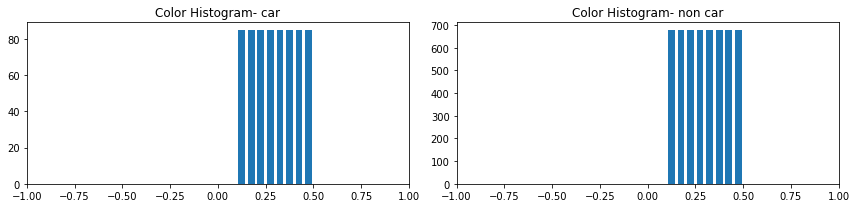

In [14]:
color_hist_car, bincen = color_hist(car_ycrcb, visualize=True)
color_hist_noncar = color_hist(noncar_ycrcb)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.bar(bincen, color_hist_car[0], width=0.035)
plt.xlim(-1, 1)
plt.title('Color Histogram- car')
plt.subplot(122)
plt.bar(bincen, color_hist_noncar[0], width=0.035)
plt.xlim(-1, 1)
plt.title('Color Histogram- non car')
fig.tight_layout()

#### Combine Features

In [15]:
class FeatureParams():
    def __init__(self):
        # HOG parameters
        self.cspace = 'YCrCb'
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 1
        self.hog_channel = 'ALL' # can be 0,1,2 or 'ALL'
        # spatial binning parameters
        self.size = (8,8)
        # color histogram parameters
        self.hist_bins = 8
        self.hist_range = (0.1,0.5)

params = FeatureParams()

In [16]:
def extract_features(image, params, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Parameters extraction
    # HOG parameters
    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    # Spatial parameters
    size = params.size
    # Histogram parameters
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    # apply color conversion if other than 'RGB'
    feature_image = convert_color(image, cspace)
    
    img_features = []
    
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)
        
    if spatial_feat == True:
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size)
        img_features.append(spatial_features)
    
    if hist_feat == True:
        # Apply color_hist() 
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        img_features.append(hist_features)
        
    return np.concatenate(img_features)
    #return np.concatenate((spatial_features, hist_features, hog_features))

### Train a Linear SVM classifier

In [17]:
car_images = list(map(lambda fname: mpimg.imread(fname), car_fnames))
noncar_images = list(map(lambda fname: mpimg.imread(fname), noncar_fnames))

In [18]:
print('Extract features...')
t = time.time()
car_features = list(map(lambda img: extract_features(img, params), car_images))
noncar_features = list(map(lambda img: extract_features(img, params), noncar_images))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

Extract features...
251.18 Seconds to extract features...


In [19]:
def split_train_test(car_features, noncar_features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
    
    # Split up data into randomized training and test sets
    rand_state = 43#np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_test(car_features, noncar_features)



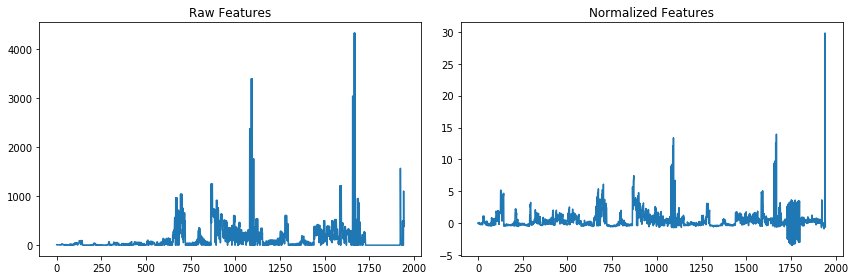

In [20]:
def normalize(X_train, X_test, visualize=False):
    # Fit a per-column scaler
    X_scaler = RobustScaler().fit(X_train)
    # Apply the scaler to X
    scaled_X_train = X_scaler.transform(X_train)
    scaled_X_test = X_scaler.transform(X_test)
    
    if visualize:
        car_ind = np.random.randint(0, len(car_features))
        # Plot an example of raw and scaled features
        fig = plt.figure(figsize=(12,4))
        plt.subplot(121)
        plt.plot(X_train[car_ind])
        plt.title('Raw Features')
        plt.subplot(122)
        plt.plot(scaled_X_train[car_ind])
        plt.title('Normalized Features')
        fig.tight_layout()
    
    return X_scaler, scaled_X_train, scaled_X_test

scaler, scaled_X_train, scaled_X_test = normalize(X_train, X_test, visualize=True)

In [21]:
def train_model(X_train, X_test, y_train, y_test, load=False):    

    # Check the training time for the SVC
    if load:
        with open('model.pkl', 'rb') as f:
            svc = pickle.load(f)
        print('SVC model loaded')
    else:
        t=time.time()
        svc = LinearSVC()
        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        with open('model','wb') as f:
            pickle.dump(svc,f)
            
    train_accuracy=svc.score(X_train, y_train)
    test_accuracy=svc.score(X_test, y_test)
    print('Train Accuracy: {}'.format(round(train_accuracy, 4)))
    print('Test Accuracy: {}'.format(round(test_accuracy, 4)))

    t = time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
    return svc

In [22]:
svc = train_model(scaled_X_train, scaled_X_test, y_train, y_test, load=True)

SVC model loaded
Train Accuracy: 0.9963
Test Accuracy: 0.9961
My SVC predicts:  [1. 0. 1. 1. 0. 1. 0. 0. 1. 1.]
For these 10 labels:  [1. 0. 1. 1. 0. 1. 0. 0. 1. 1.]
0.00235 Seconds to predict 10 labels with SVC


TODO:
* use GridSearch to find optimal parameters

### Search for Vehicle in Image - Sliding Window

In [23]:
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    for bbox in bboxes:
        (x1,y1),(x2,y2) = bbox
        cv2.rectangle(draw_img, (x1, y1), (x2, y2), color, thick)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    return draw_img

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [24]:
# Define a function you will pass an image
# and it will return a list of windows contain cars 
def search_windows(img, clf, scaler, params, y_start_stop=[400, 700], xy_window=(64, 64), xy_overlap=(0.8, 0.8)):
    img = img.astype(np.float32)/255
    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features(window_img, params)
        #5) Scale extracted features to be fed to classifier
        window_features = scaler.transform(features.reshape(1, -1))
        #6) Predict using your classifier
        pred = clf.predict(window_features)
        #7) If positive (prediction == 1) then save the window
        if pred == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [25]:
test_fnames = glob.glob('test_images/*.jpg')
test_images = list(map(lambda fname: mpimg.imread(fname), sorted(test_fnames)))
car_boxes_images = list(map(lambda img: draw_boxes(img, search_windows(img, svc, scaler, params)), test_images))

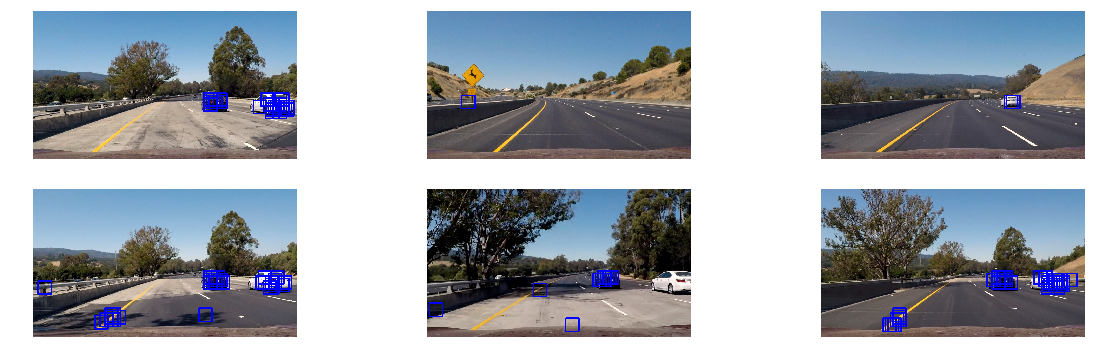

In [26]:
def show_boxes(images, cols = 3, rows = 0):
    rows = int(np.ceil(len(images)/cols))
    f, axs = plt.subplots(rows, cols, figsize=(20, 3*rows))
    axs = axs.ravel()
    for i in range(len(axs)):
        if i < len(images):
            axs[i].axis('off')
            axs[i].imshow(images[i])
        else:
            f.delaxes(axs[i])

show_boxes(car_boxes_images)

### Hog Sub-sampling Window Search

In [27]:
def find_cars(img, clf, scaler, params, y_start_stop=[360, 700], x_start_stop=[380, 1280], xy_window=(64, 64), xy_overlap=(0.85, 0.85), window=64, cells_per_step=1, scale=1.5, return_all=False):
    
    # HOG parameters
    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel # can be 0,1,2 or 'ALL'
    # spatial binning parameters
    spatial_size = params.size
    # color histogram parameters
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    ystart, ystop = y_start_stop
    xstart, xstop = x_start_stop
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace=cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)

            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1)) 
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or return_all:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return car_windows


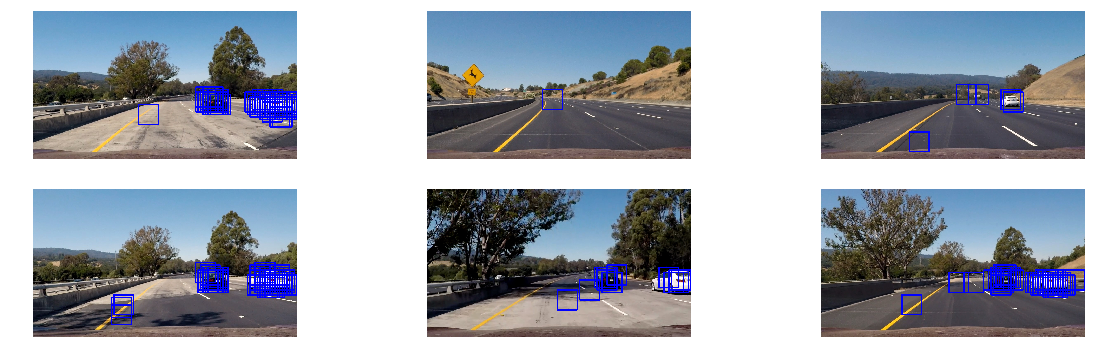

In [28]:

car_boxes = list(map(lambda img: draw_boxes(img, find_cars(img, svc, scaler, params)), test_images))
show_boxes(car_boxes)

### Multi-scale Windows

In [29]:
def multi_scale_find_cars(img, clf, scaler, params, return_all=False):
    scales = np.array([1, 1.5, 2, 3])
    y_start_stops = [[400,464],[400,496],[432,560],[448,644]]
    x_start_stops = [[620,1000],[560,1280],[500,1280],[380,1280]]
    car_windows = []
    for i in range(len(scales)):
        scale = scales[i]
        for j in range(2):
            y_offset = j*16
            windows = find_cars(img, svc, scaler, params, y_start_stop=[y_start_stops[i][0],y_start_stops[i][1]+y_offset], x_start_stop=x_start_stops[i], scale=scale, return_all=return_all)
            car_windows.extend(windows)
    return np.array(car_windows)

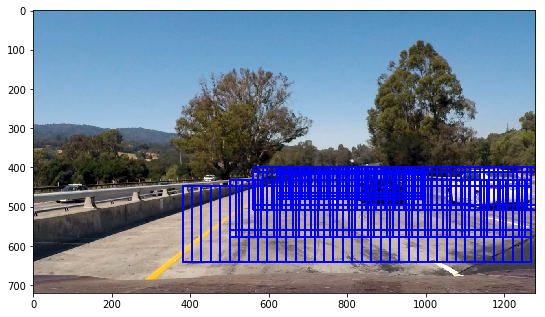

In [30]:
all_windows = multi_scale_find_cars(test_images[0], svc, scaler, params, return_all=True)
window_img = draw_boxes(test_images[0], all_windows, color=(0, 0, 255), thick=3)                    
plt.imshow(window_img)

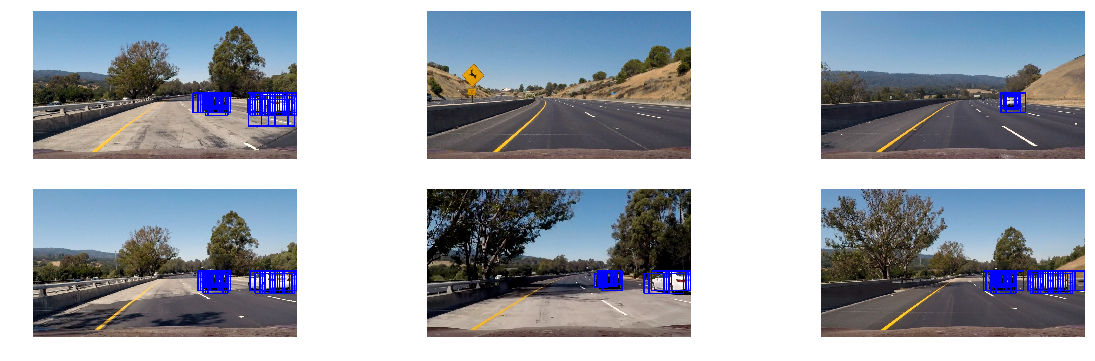

In [31]:
car_boxes = list(map(lambda img: draw_boxes(img, multi_scale_find_cars(img, svc, scaler, params)), test_images))
show_boxes(car_boxes)

### Multiple Detection and False Positives

In [32]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [33]:
def draw_labeled_windows(image, boxes, threshold=2):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxes) 
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return heatmap, labels, draw_img

In [34]:
def output_video_frames(src_path):
    clip1 = VideoFileClip(src_path)
    return clip1.write_images_sequence('output_images/frame%04d.jpeg')
frame_fnames = output_video_frames('test_video.mp4')

[MoviePy] Writing frames output_images/frame%04d.jpeg.

38it [00:03, 10.39it/s]                      

[MoviePy]: Done writing frames output_images/frame%04d.jpeg.



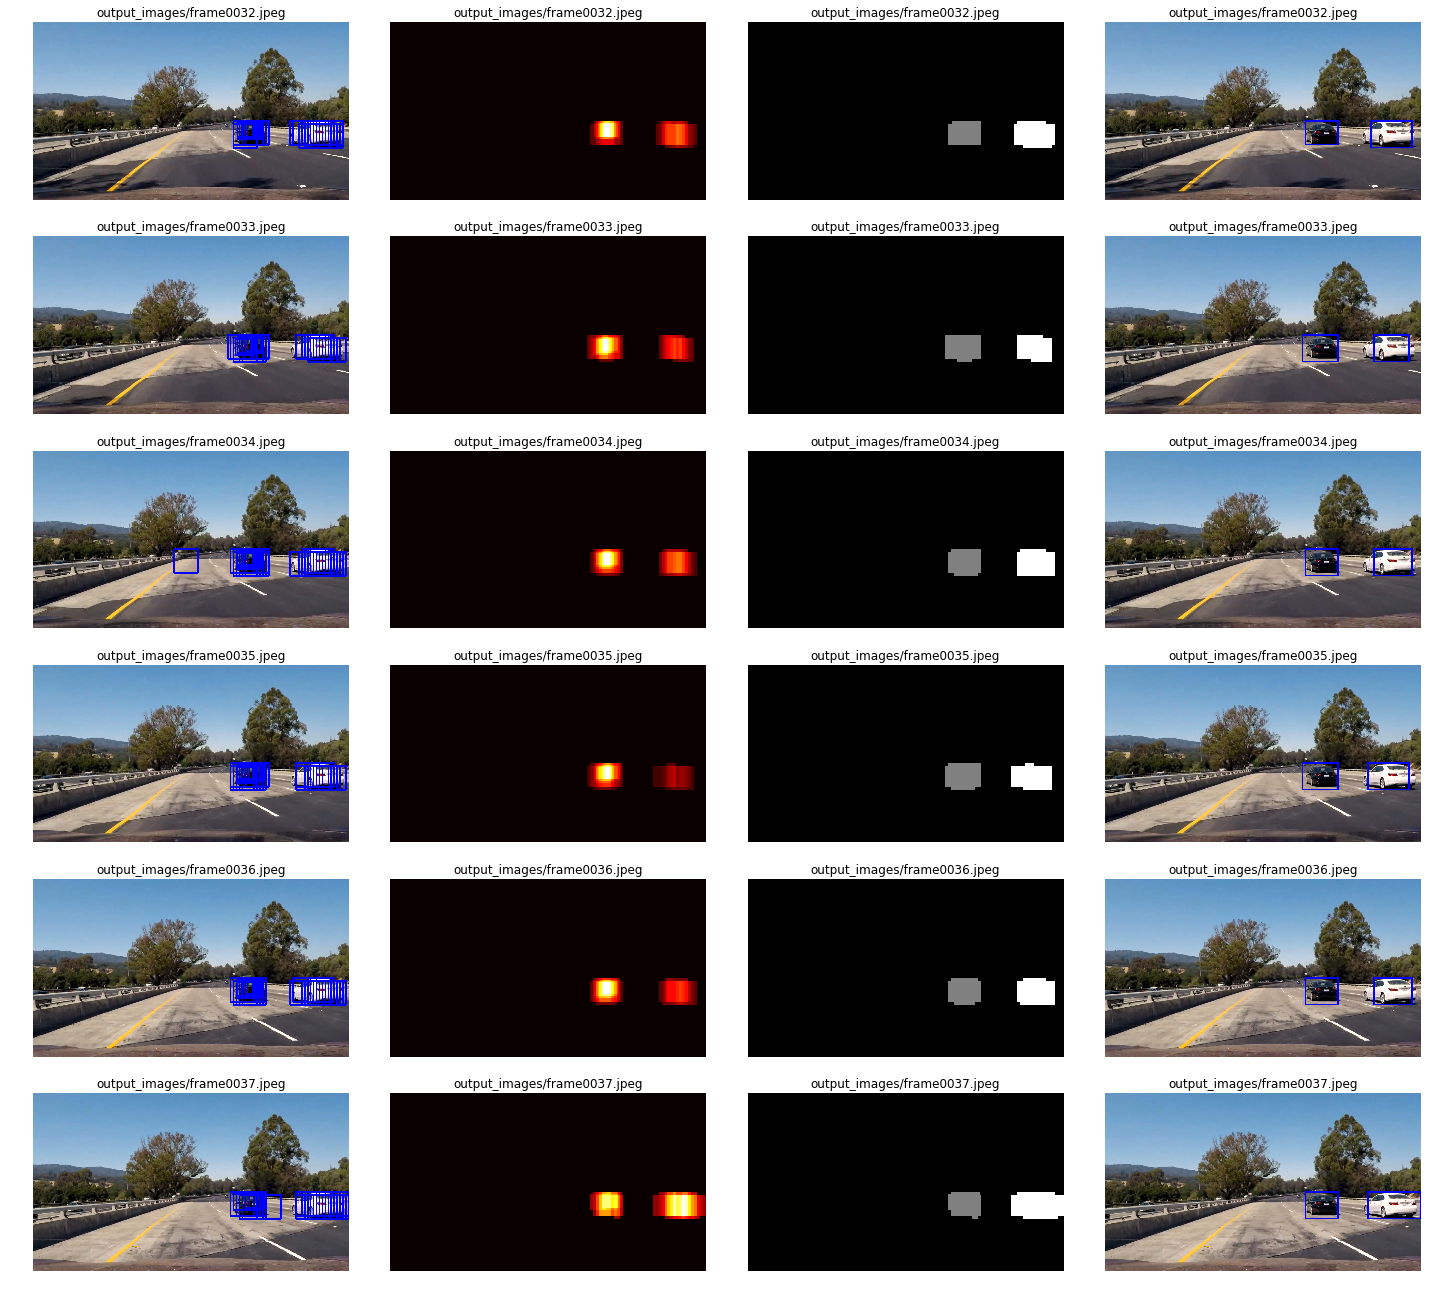

In [36]:
num_frames = 6
f, axs = plt.subplots(num_frames,4, figsize=(20,18))
f.tight_layout()
for i in range(num_frames):
    fname = frame_fnames[-(num_frames-i)]
    img = mpimg.imread(fname)
    car_windows = multi_scale_find_cars(img, svc, scaler, params)
    car_boxes = draw_boxes(img, car_windows)
    heatmap, labels, draw_image = draw_labeled_windows(img, car_windows)

    axs[i][0].set_title(fname)
    axs[i][0].axis('off')
    axs[i][0].imshow(car_boxes)
    axs[i][1].set_title(fname)
    axs[i][1].axis('off')
    axs[i][1].imshow(heatmap, cmap='hot')
    axs[i][2].set_title(fname)
    axs[i][2].axis('off')
    axs[i][2].imshow(labels[0], cmap='gray')
    axs[i][3].set_title(fname)
    axs[i][3].axis('off')
    axs[i][3].imshow(draw_image)
    

### Video Pipeline

In [37]:
from collections import deque
recent_detected = deque(maxlen=10) 

def pipeline(image, svc=svc, scaler=scaler, params=params, combine_detection=True):
    global recent_detected
    car_windows = multi_scale_find_cars(image, svc, scaler, params)
    if combine_detection:
        recent_detected.append(car_windows)
        #[item for sublist in list for item in sublist]
        combined_detected = np.array([window for detection in recent_detected for window in detection]).astype(int)
        _,_,draw_image = draw_labeled_windows(image, combined_detected, threshold=24)
    else:
        _,_,draw_image = draw_labeled_windows(image, car_windows, threshold=1)
    return draw_image

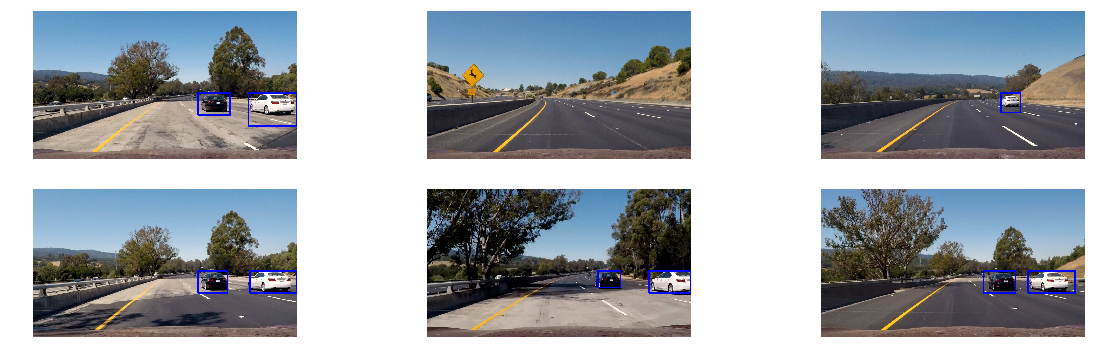

In [38]:
pipeline_images = list(map(lambda img: pipeline(img, combine_detection=False), test_images))
show_boxes(pipeline_images)

In [39]:
def test_video(src_path, dst_path, subclip_range=None):
    global recent_detected
    recent_detected.clear()
    
    project_output = dst_path        

    if subclip_range is None:
        clip1 = VideoFileClip(src_path)
    else:
        clip1 = VideoFileClip(src_path).subclip(subclip_range)
    white_clip = clip1.fl_image(pipeline)

    %time white_clip.write_videofile(project_output, audio=False)

In [40]:
test_video('test_video.mp4','test_videos_output/test_video.mp4')

[MoviePy] >>>> Building video test_videos_output/test_video.mp4
[MoviePy] Writing video test_videos_output/test_video.mp4


 97%|█████████▋| 38/39 [00:50<00:01,  1.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video.mp4 

CPU times: user 47.9 s, sys: 1.72 s, total: 49.6 s
Wall time: 52.8 s


In [41]:
test_video('project_video.mp4','test_videos_output/project_video.mp4')

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [26:45<00:01,  1.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 25min 34s, sys: 50.2 s, total: 26min 24s
Wall time: 26min 47s
